In [1]:
# importing packages and modules
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import minimize, check_grad
from utils import *
from io_utils import *
from plotting_utils import *
from analysis_utils import *
import dynamic_glmhmm
from scipy.stats import multivariate_normal, norm

colorsStates = ['tab:orange','tab:blue', 'tab:green','tab:red'] 
sns.set_context("talk")

In [2]:
# setting hyperparameters
# S = 30 # sessions
# T = 500 # trials per session
# N = T * S # total data points
C = 2 # classes/outputs
K = 3 #3 # states
D = 2 # features/regressors (sensory & bias)
truepi = [0.9,0.05,0.05] #np.ones((K))/K

# # session start indices
# sessInd = []
# for sess in range(0,S):
#     sessInd.append(sess*T)
# sessInd.append(N)

In [3]:
ibl_data_path = '../data_IBL'
dfAll = pd.read_csv(ibl_data_path + '/Ibl_processed.csv')

labChosen =  ['angelakilab','churchlandlab','wittenlab']
subjectsAll = []
for lab in labChosen:
    subjects = np.unique(dfAll[dfAll['lab'] == lab]['subject']).tolist()
    subjectsAll = subjectsAll + subjects

# missing data
if ('NYU-01' in subjectsAll):
    subjectsAll.remove('NYU-01')
if ('NYU-06' in subjectsAll):
    subjectsAll.remove('NYU-06')
if ('CSHL_007' in subjectsAll):
    subjectsAll.remove('CSHL_007')
if ('CSHL049' in subjectsAll):
    subjectsAll.remove('CSHL049')

avg_session_length = 995 # from ibl_witten_15

In [4]:
# for subject in subjectsAll:
#     print(subject)
#     x, _, sessInd, correctSide = get_mouse_design(dfAll, subject=subject, sessStop=30, signedStimulus=True, pTanh=None)
#     print((np.array(sessInd[1:])-np.array(sessInd[:-1]))[:10].sum())

In [5]:
# transformation functions for hypothetical trajectories (only used for plotting)
def generalized_exp(a, b, c, d, x):
    return a * np.exp(b * x + c) + d
def generalized_log(a, b, c, d, x):
    return a * np.log(b * x + c) + d
def generalized_sigmoid(a, b, c, d, x):
    return c * (1 / (1 + np.exp(-a * x + b))) + d

In [6]:
ibl_data_path = '../data_IBL'
dfAll = pd.read_csv(ibl_data_path + '/Ibl_processed.csv')

pTanh = None
x, _, sessInd, correctSide = get_mouse_design(dfAll, subject='ibl_witten_06', sessStop=30, signedStimulus=True, pTanh=pTanh)
x = x[:,:2]
x = np.repeat(x, 1, axis=0)
print(np.unique(x[:,1]))
sess = len(sessInd) - 1
sessInd = [1*x for x in sessInd]
N = sessInd[-1]
print(sess)
print(sessInd)

[-1.85036154 -0.92518077 -0.46259039 -0.23129519 -0.1156476   0.
  0.1156476   0.23129519  0.46259039  0.92518077  1.85036154]
30
[0, 111, 1112, 2479, 3844, 5591, 6822, 7826, 8933, 9680, 10641, 11880, 13300, 13801, 14394, 15661, 16666, 18159, 19213, 20435, 21123, 21537, 22928, 24652, 25202, 27093, 27900, 28259, 29355, 29583, 30209]


In [7]:
# # SIMULATING LARGE NUMBER OF TRIALS
# pTanh = None
# sess = 3
# sessInd = [10000 * x for x in range(sess+1)]
# N = sessInd[-1]
# x = np.ones((N,2))
# x_animal, _, _, correctSide = get_mouse_design(dfAll, subject='ibl_witten_06', sessStop=30, signedStimulus=True, pTanh=pTanh)
# val = np.unique(x_animal[:,1])
# x[:,1] = np.random.choice(val, size=x[:,1].shape)
# print(sess)
# print(sessInd)

# K = 1
# ourP = np.ones((K,K))
# ourW = np.zeros((sess,K,D))
# ourW[:,0,1] = np.linspace(0,2.5,sess) # state 1 sensory (increasing)
# ourW[:,0,0] = np.linspace(-0.3,0,sess) # state 1 bias (decreasing)

# trueW = np.zeros((N,K,D,C))
# trueP = np.zeros((N,K,K))

# ourW[:,0,1] = generalized_log(0.75, 0.7, 0.1, 1.8, ourW[:,0,1])
# ourW[:,0,0] = generalized_exp(-0.4,-1.5, 0, 0.35, ourW[:,0,0]) 

# for s in range(0,sess):
#     # sessInd.append(sess*T)
#     # for t in range(0,T):
#     trueW[sessInd[s]:sessInd[s+1],:,:,1] = ourW[s,:,:]
#     trueP[sessInd[s]:sessInd[s+1]] = ourP
#     # if s < 10:
#     #     trueP[sessInd[s]:sessInd[s+1]] = oneP
#     # else:
#         # trueP[sessInd[s]:sessInd[s+1]] = ourP
# # sessInd.append(N)


# fig, axes = plt.subplots(1, figsize = (15,5.5), dpi=400)
# axes.set_ylim(-2.5,2.5)
# axes.set_ylabel('weights', size=22)
# axes.set_xlabel('session', size=22)
# axes.axhline(0, alpha=0.3, color='black',linestyle='--')
# axes.plot(range(1,sess+1), trueW[sessInd[:-1],0,1,1],color=colorsStates[0],linewidth=5,label=f'state 1 sensory', alpha=1, linestyle='-')
# axes.plot(range(1,sess+1), trueW[sessInd[:-1],0,0,1], color='peachpuff',linewidth=5,label=f'state 1 bias', alpha=1, linestyle='-')


In [8]:
# dGLMHMM = dynamic_glmhmm.dynamic_GLMHMM(N,K,D,C)
# x, y, z = dGLMHMM.simulate_data(trueW, trueP, truepi, sessInd)


# model_type = 'partial'
# present = np.ones((N))
# sigma = np.ones((K,D)) * 1000 #0.5
# dynamicP, pi, dynamicW, _ = dGLMHMM.fit(x, y, present, initP=trueP, initpi=truepi, initW=trueW, sigma=sigma, sessInd=sessInd, maxIter=1, tol=1e-4, priorDirP=[10,1], model_type=model_type, alpha=1, A=trueP.mean(axis=0), L2penaltyW=0) # fit the model
# # partialP, partialpi, partialW, _ = dGLMHMM.fit(x, y,  present, initP=standardP, initpi=standardpi, initW=standardW, sigma=sigma, sessInd=sessInd, maxIter=250, tol=1e-4, priorDirP=[10,1], model_type=model_type) # fit the model
# fig, axes = plt.subplots(2,1, figsize=(10,6), sharex=True)
# plotting_weights_per_feature(dynamicW, sessInd=sessInd, axes=axes, yLim=[[-3,3],[-3,3]], trueW=trueW, labels=['bias', 'sensory'])

In [9]:
# True Transition Matrix
ourP = np.zeros((3,3))
ourP[0,0]=0.95
ourP[0,1]=0.025
ourP[0,2]=0.025
ourP[1,1]=0.95
ourP[1,0]=0.025
ourP[1,2]=0.025
ourP[2,2]=0.95
ourP[2,1]=0.025
ourP[2,0]=0.025
print("True Transition Matrix P")
print(ourP)

oneP = np.zeros((3,3))
oneP[0,0]=0.999
oneP[0,1]=0.0005
oneP[0,2]=0.0005
oneP[1,1]=0.0005
oneP[1,0]=0.999
oneP[1,2]=0.0005
oneP[2,2]=0.0005
oneP[2,1]=0.0005
oneP[2,0]=0.999

True Transition Matrix P
[[0.95  0.025 0.025]
 [0.025 0.95  0.025]
 [0.025 0.025 0.95 ]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


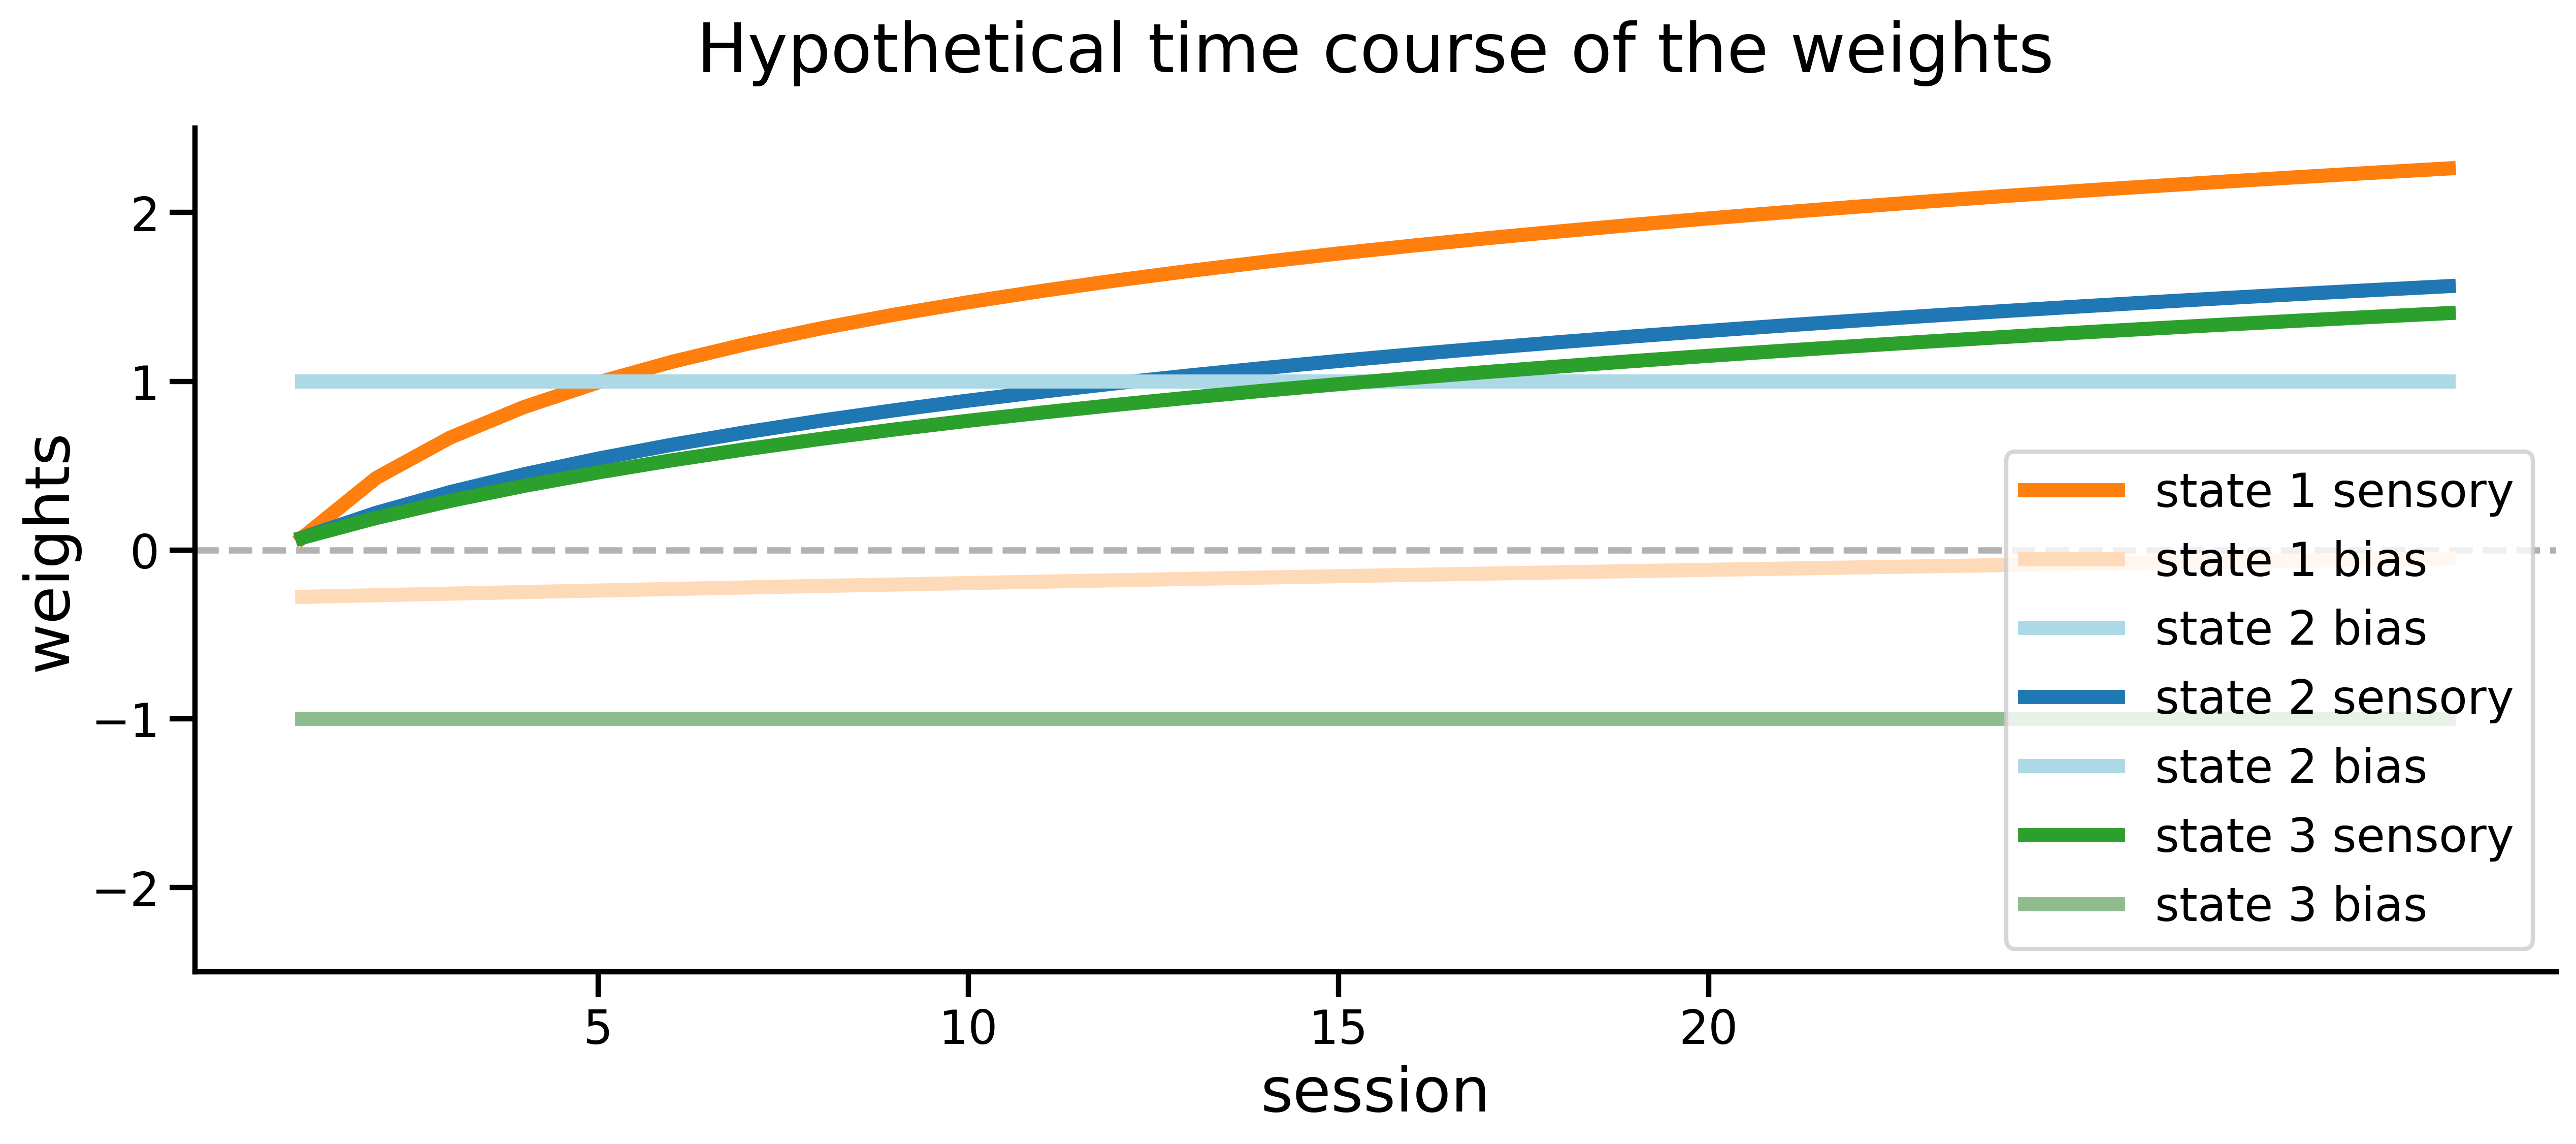

In [10]:
# True Weights and Session Start Indices
ourW = np.zeros((sess,K,D))
ourW[:,0,1] = np.linspace(0,2.5,sess) # state 1 sensory (increasing)
ourW[:,0,0] = np.linspace(-0.3,0,sess) # state 1 bias (decreasing)
ourW[:,1,1] = np.linspace(0,0.9,sess) # state 2 sensory (flat 0)
ourW[:,1,0] = 1 # state 2 bias (flat 1)
ourW[:,2,1] = np.linspace(0,0.7,sess) # state 2 sensory (flat 0)
ourW[:,2,0] = -1 # state 2 bias (flat 1)

# transformation of weights to get desired hypothetical parameters
ourW[:,0,1] = generalized_log(0.75, 0.7, 0.1, 1.8, ourW[:,0,1]) # transformation with log
ourW[:,0,0] = generalized_exp(-0.4,-1.5, 0, 0.35, ourW[:,0,0]) # transformation with exp
ourW[:,1,1] = generalized_log(0.75, 0.7, 0.1, 1.8, ourW[:,1,1]) # transformation wtih log
ourW[:,2,1] = generalized_log(0.75, 0.7, 0.1, 1.8, ourW[:,2,1]) # transformation wtih log

trueW = np.zeros((N,K,D,C))
trueP = np.zeros((N,K,K))
# sessInd = []
for s in range(0,sess):
    # sessInd.append(sess*T)
    # for t in range(0,T):
    trueW[sessInd[s]:sessInd[s+1],:,:,1] = ourW[s,:,:]
    # trueP[sessInd[s]:sessInd[s+1]] = ourP
    if s < 10:
        trueP[sessInd[s]:sessInd[s+1]] = oneP
    else:
        trueP[sessInd[s]:sessInd[s+1]] = ourP
# sessInd.append(N)


# FIGURE 1C
fig, axes = plt.subplots(1, figsize = (15,5.5), dpi=400)
axes.set_ylim(-2.5,2.5)
axes.set_ylabel('weights', size=22)
axes.set_xlabel('session', size=22)
axes.axhline(0, alpha=0.3, color='black',linestyle='--')
axes.plot(range(1,sess+1), trueW[sessInd[:-1],0,1,1],color=colorsStates[0],linewidth=5,label=f'state 1 sensory', alpha=1, linestyle='-')
axes.plot(range(1,sess+1), trueW[sessInd[:-1],0,0,1], color='peachpuff',linewidth=5,label=f'state 1 bias', alpha=1, linestyle='-')
axes.plot(range(1,sess+1),trueW[sessInd[:-1],1,0,1],color='lightblue',linewidth=5,label=f'state 2 bias', alpha=1, linestyle='-')
axes.plot(range(1,sess+1), trueW[sessInd[:-1],1,1,1],color=colorsStates[1],linewidth=5,label=f'state 2 sensory', alpha=1, linestyle='-')
axes.plot(range(1,sess+1),trueW[sessInd[:-1],1,0,1],color='lightblue',linewidth=5,label=f'state 2 bias', alpha=1, linestyle='-')
axes.plot(range(1,sess+1), trueW[sessInd[:-1],2,1,1],color=colorsStates[2],linewidth=5,label=f'state 3 sensory', alpha=1, linestyle='-')
axes.plot(range(1,sess+1), trueW[sessInd[:-1],2,0,1],color='darkseagreen',linewidth=5,label=f'state 3 bias', alpha=1, linestyle='-')
# for earlySess in [3,10,19]: # example sessions
#     axes.scatter(earlySess, trueW[sessInd[earlySess-1],0,0,1],color='black',alpha=1,zorder=2)
#     axes.scatter(earlySess,trueW[sessInd[earlySess-1],0,1,1],color='black',alpha=1,zorder=2)
#     axes.scatter(earlySess,trueW[sessInd[earlySess-1],1,0,1],color='black',alpha=1,zorder=2)
#     axes.scatter(earlySess,trueW[sessInd[earlySess-1],1,1,1],color='black',alpha=1,zorder=2)
axes.legend(loc='lower right')
axes.set_title('Hypothetical time course of the weights', size=24, pad=20)
axes.spines[['right', 'top']].set_visible(False)
axes.set_xticks([5,10,15,20],[5,10,15,20])
plt.savefig(f'../figures/Figure1_simulated_weights.eps', bbox_inches='tight', dpi=300, format='eps')

In [11]:
dGLMHMM = dynamic_glmhmm.dynamic_GLMHMM(N,K,D,C)
z = np.zeros((N)).astype(int)
y = np.zeros((x.shape[0],C)).astype(int)
for t in range(0, N):
    if (t in sessInd[:-1]): # beginning of session has a new draw for latent
        z[t] = np.random.choice(range(0, K), p=truepi)
    else:
        z[t] = np.random.choice(range(0, K), p=trueP[t,z[t-1],:])
        
# observation probabilities
phi = dGLMHMM.observation_probability(x, trueW)

for t in range(0, N):
    y[t,int(np.random.binomial(n=1, p=phi[t,z[t],1]))]=1 
        
y = reshapeObs(y) # reshaping from n x c to n x 1

In [12]:
# # CHECKING THAT FITTING FROM TRUE PARAMETERS WORKS FINE
# model_type = 'dynamic'
# present = np.ones((N))
# sigma = np.ones((K,D)) * 0.2 #0.5
# dynamicP, pi, dynamicW, _ = dGLMHMM.fit(x, y, present, initP=trueP, initpi=truepi, initW=trueW, sigma=sigma, sessInd=sessInd, maxIter=10, tol=1e-4, priorDirP=[10,1], model_type=model_type, alpha=1, A=trueP.mean(axis=0), L2penaltyW=0, fit_init_states=True) # fit the model
# # partialP, partialpi, partialW, _ = dGLMHMM.fit(x, y,  present, initP=standardP, initpi=standardpi, initW=standardW, sigma=sigma, sessInd=sessInd, maxIter=250, tol=1e-4, priorDirP=[10,1], model_type=model_type) # fit the model
# fig, axes = plt.subplots(2,1, figsize=(10,6), sharex=True)
# plotting_weights_per_feature(dynamicW, sessInd=sessInd, axes=axes, yLim=[[-3,3],[-3,3]], trueW=trueW, labels=['bias', 'sensory'])

0


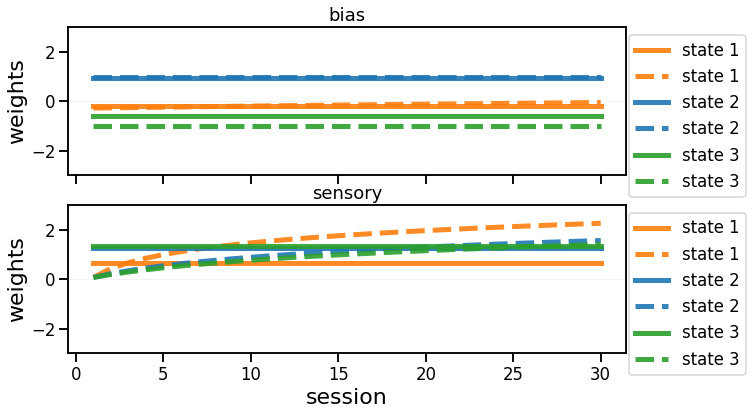

In [13]:
model_type = 'standard'
# initP, initpi, initW = dGLMHMM.generate_param(sessInd=sessInd, transitionDistribution=['dirichlet', (5, 1)], weightDistribution=['uniform', (-2,2)], model_type=model_type) 
present = np.ones((N)).astype(int)
irrelevantSigma = np.ones((K,D))
standardP, standardpi, standardW, _ = dGLMHMM.fit(x, y,  present, initP=trueP, initpi=truepi, initW=trueW, sigma=irrelevantSigma, sessInd=sessInd, maxIter=50, tol=1e-4, priorDirP=None, model_type=model_type, fit_init_states=False) # fit the model
fig, axes = plt.subplots(2,1, figsize=(10,6), sharex=True)
# reorder = [1,0]
plotting_weights_per_feature(standardW, sessInd=sessInd, axes=axes, yLim=[[-3,3],[-3,3]], trueW=trueW, labels=['bias', 'sensory'])

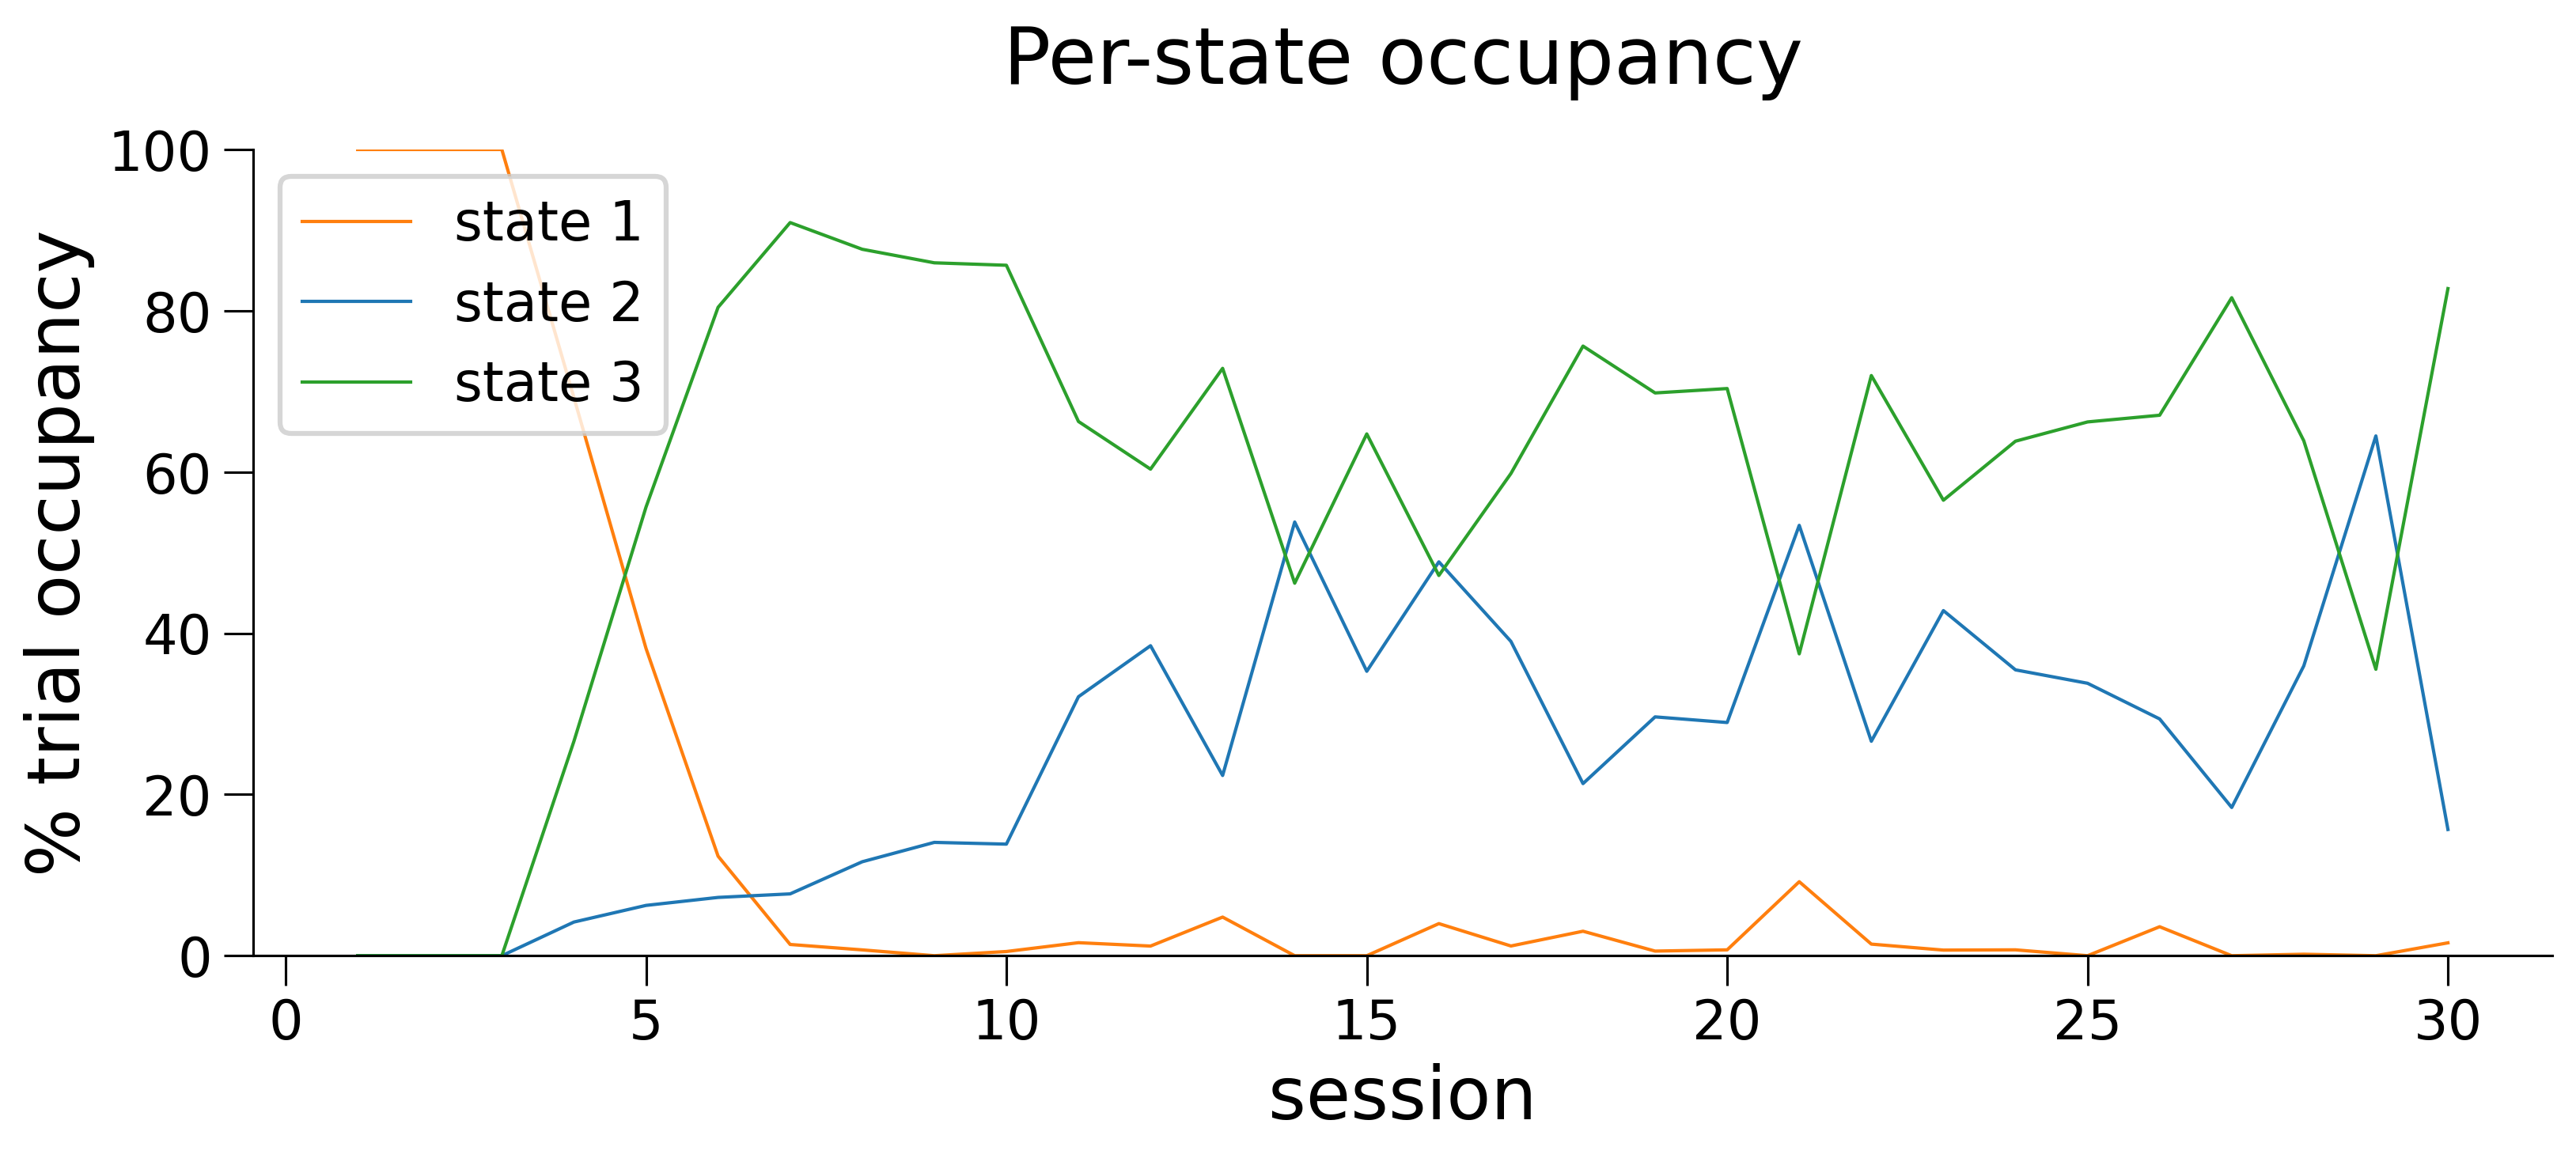

In [14]:
presentAll = np.ones((N))
gamma = dGLMHMM.posterior_likelihood_of_each_state(standardP, truepi, standardW, x, y, presentAll, sessInd, sortedStateInd=None)
fig, axes = plt.subplots(1, figsize = (12.5,4.5), dpi=300) 
_ = plot_state_occupancy_sessions(gamma[:sessInd[-1]], sessInd[:], axes, colors=colorsStates, linewidth=1, size=24)
axes.spines[['right', 'top']].set_visible(False)
axes.spines[['left', 'bottom']].set_linewidth(0.75)
axes.set_title('Per-state occupancy', size=24, pad=20)
axes.legend()
axes.set_xlabel('session', size=22)
axes.xaxis.set_tick_params(width=0.75)
axes.yaxis.set_tick_params(width=0.75)

In [17]:
model_type = 'partial'
present = np.ones((N))
sigma = np.ones((K,D)) * 1 # variability in stimulus weights
sigma[:,0] = 0.01 # # variability in bias weights
partialP, partialpi, partialW, _ = dGLMHMM.fit(x, y,  present, initP=standardP, initpi=truepi, initW=standardW, sigma=sigma, sessInd=sessInd, maxIter=250, tol=1e-4, priorDirP=None, model_type=model_type) # fit the model
# partialP, partialpi, partialW, _ = dGLMHMM.fit(x, y,  present, initP=standardP, initpi=standardpi, initW=standardW, sigma=sigma, sessInd=sessInd, maxIter=250, tol=1e-4, priorDirP=[10,1], model_type=model_type) # fit the model
fig, axes = plt.subplots(2,1, figsize=(10,6), sharex=True)
plotting_weights_per_feature(partialW, sessInd=sessInd, axes=axes, yLim=[[-3,3],[-3,3]], trueW=trueW, labels=['bias', 'sensory'])

0
100


In [1]:
presentAll = np.ones((N))
gamma = dGLMHMM.posterior_likelihood_of_each_state(standardP, truepi, standardW, x, y, presentAll, sessInd, sortedStateInd=None)
fig, axes = plt.subplots(1, figsize = (12.5,4.5), dpi=300) 
_ = plot_state_occupancy_sessions(gamma[:sessInd[-1]], sessInd[:], axes, colors=colorsStates, linewidth=1, size=24)
axes.spines[['right', 'top']].set_visible(False)
axes.spines[['left', 'bottom']].set_linewidth(0.75)
axes.set_title('Per-state occupancy', size=24, pad=20)
axes.legend()
axes.set_xlabel('session', size=22)
axes.xaxis.set_tick_params(width=0.75)
axes.yaxis.set_tick_params(width=0.75)

NameError: name 'np' is not defined

In [25]:
model_type = 'dynamic'
present = np.ones((N))
dynamicP, pi, dynamicW, _ = dGLMHMM.fit(x, y, present, initP=partialP, initpi=truepi, initW=partialW, sigma=sigma, sessInd=sessInd, maxIter=250, tol=1e-4, priorDirP=None, model_type=model_type, alpha=1, A=trueP.mean(axis=0), L2penaltyW=0) # fit the model
# partialP, partialpi, partialW, _ = dGLMHMM.fit(x, y,  present, initP=standardP, initpi=standardpi, initW=standardW, sigma=sigma, sessInd=sessInd, maxIter=250, tol=1e-4, priorDirP=[10,1], model_type=model_type) # fit the model
fig, axes = plt.subplots(2,1, figsize=(10,6), sharex=True)
plotting_weights_per_feature(dynamicW, sessInd=sessInd, axes=axes, yLim=[[-3,3],[-3,3]], trueW=trueW, labels=['bias', 'sensory'])

0


KeyboardInterrupt: 

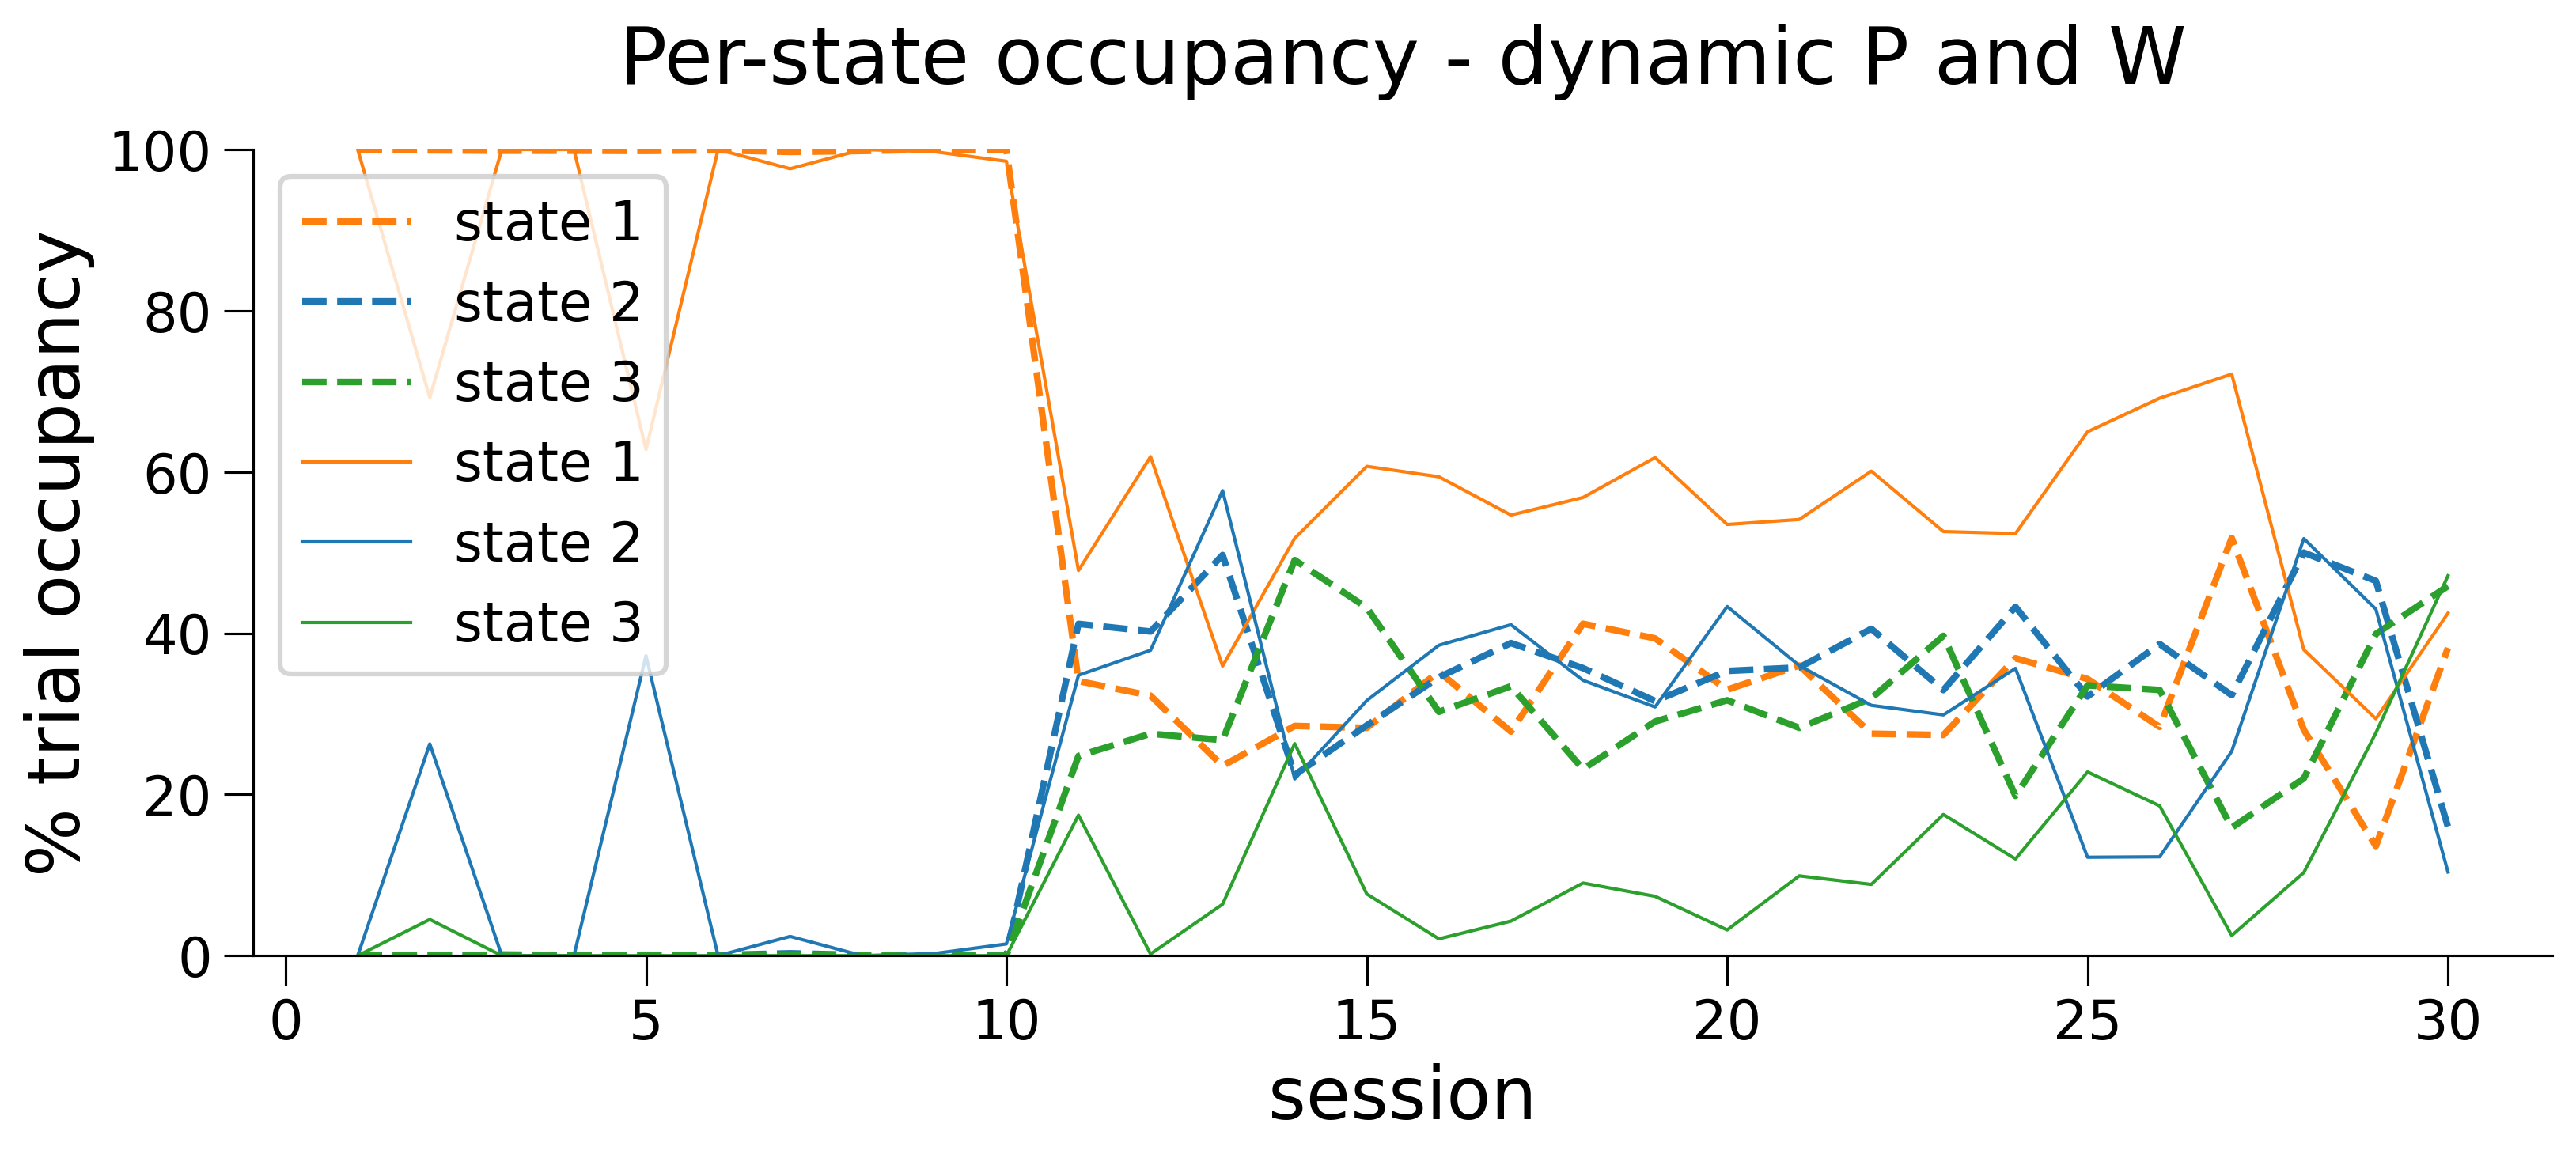

In [ ]:
presentAll = np.ones((N))
gamma = dGLMHMM.posterior_likelihood_of_each_state(dynamicP, truepi, dynamicW, x, y, presentAll, sessInd, sortedStateInd=None)
fig, axes = plt.subplots(1, figsize = (12.5,4.5), dpi=300) 

count = np.zeros((len(sessInd)-1,K))
for sess in range(0,len(sessInd)-1):
    for k in range(0,K):
        count[sess,k] = np.where(z[sessInd[sess]:sessInd[sess+1]] == k)[0].shape[0]/(sessInd[sess+1]-sessInd[sess]) * 100
for k in range(0,K):
    axes.plot(range(1,len(sessInd)), count[:,k], color=colorsStates[k], linewidth=2, label=f'state {k+1}', linestyle='--')


_ = plot_state_occupancy_sessions(gamma[:sessInd[-1]], sessInd[:], axes, colors=colorsStates, linewidth=1, size=24)
axes.spines[['right', 'top']].set_visible(False)
axes.spines[['left', 'bottom']].set_linewidth(0.75)
axes.set_title('Per-state occupancy - dynamic P and W', size=24, pad=20)
axes.legend()
axes.set_xlabel('session', size=22)
axes.xaxis.set_tick_params(width=0.75)
axes.yaxis.set_tick_params(width=0.75)

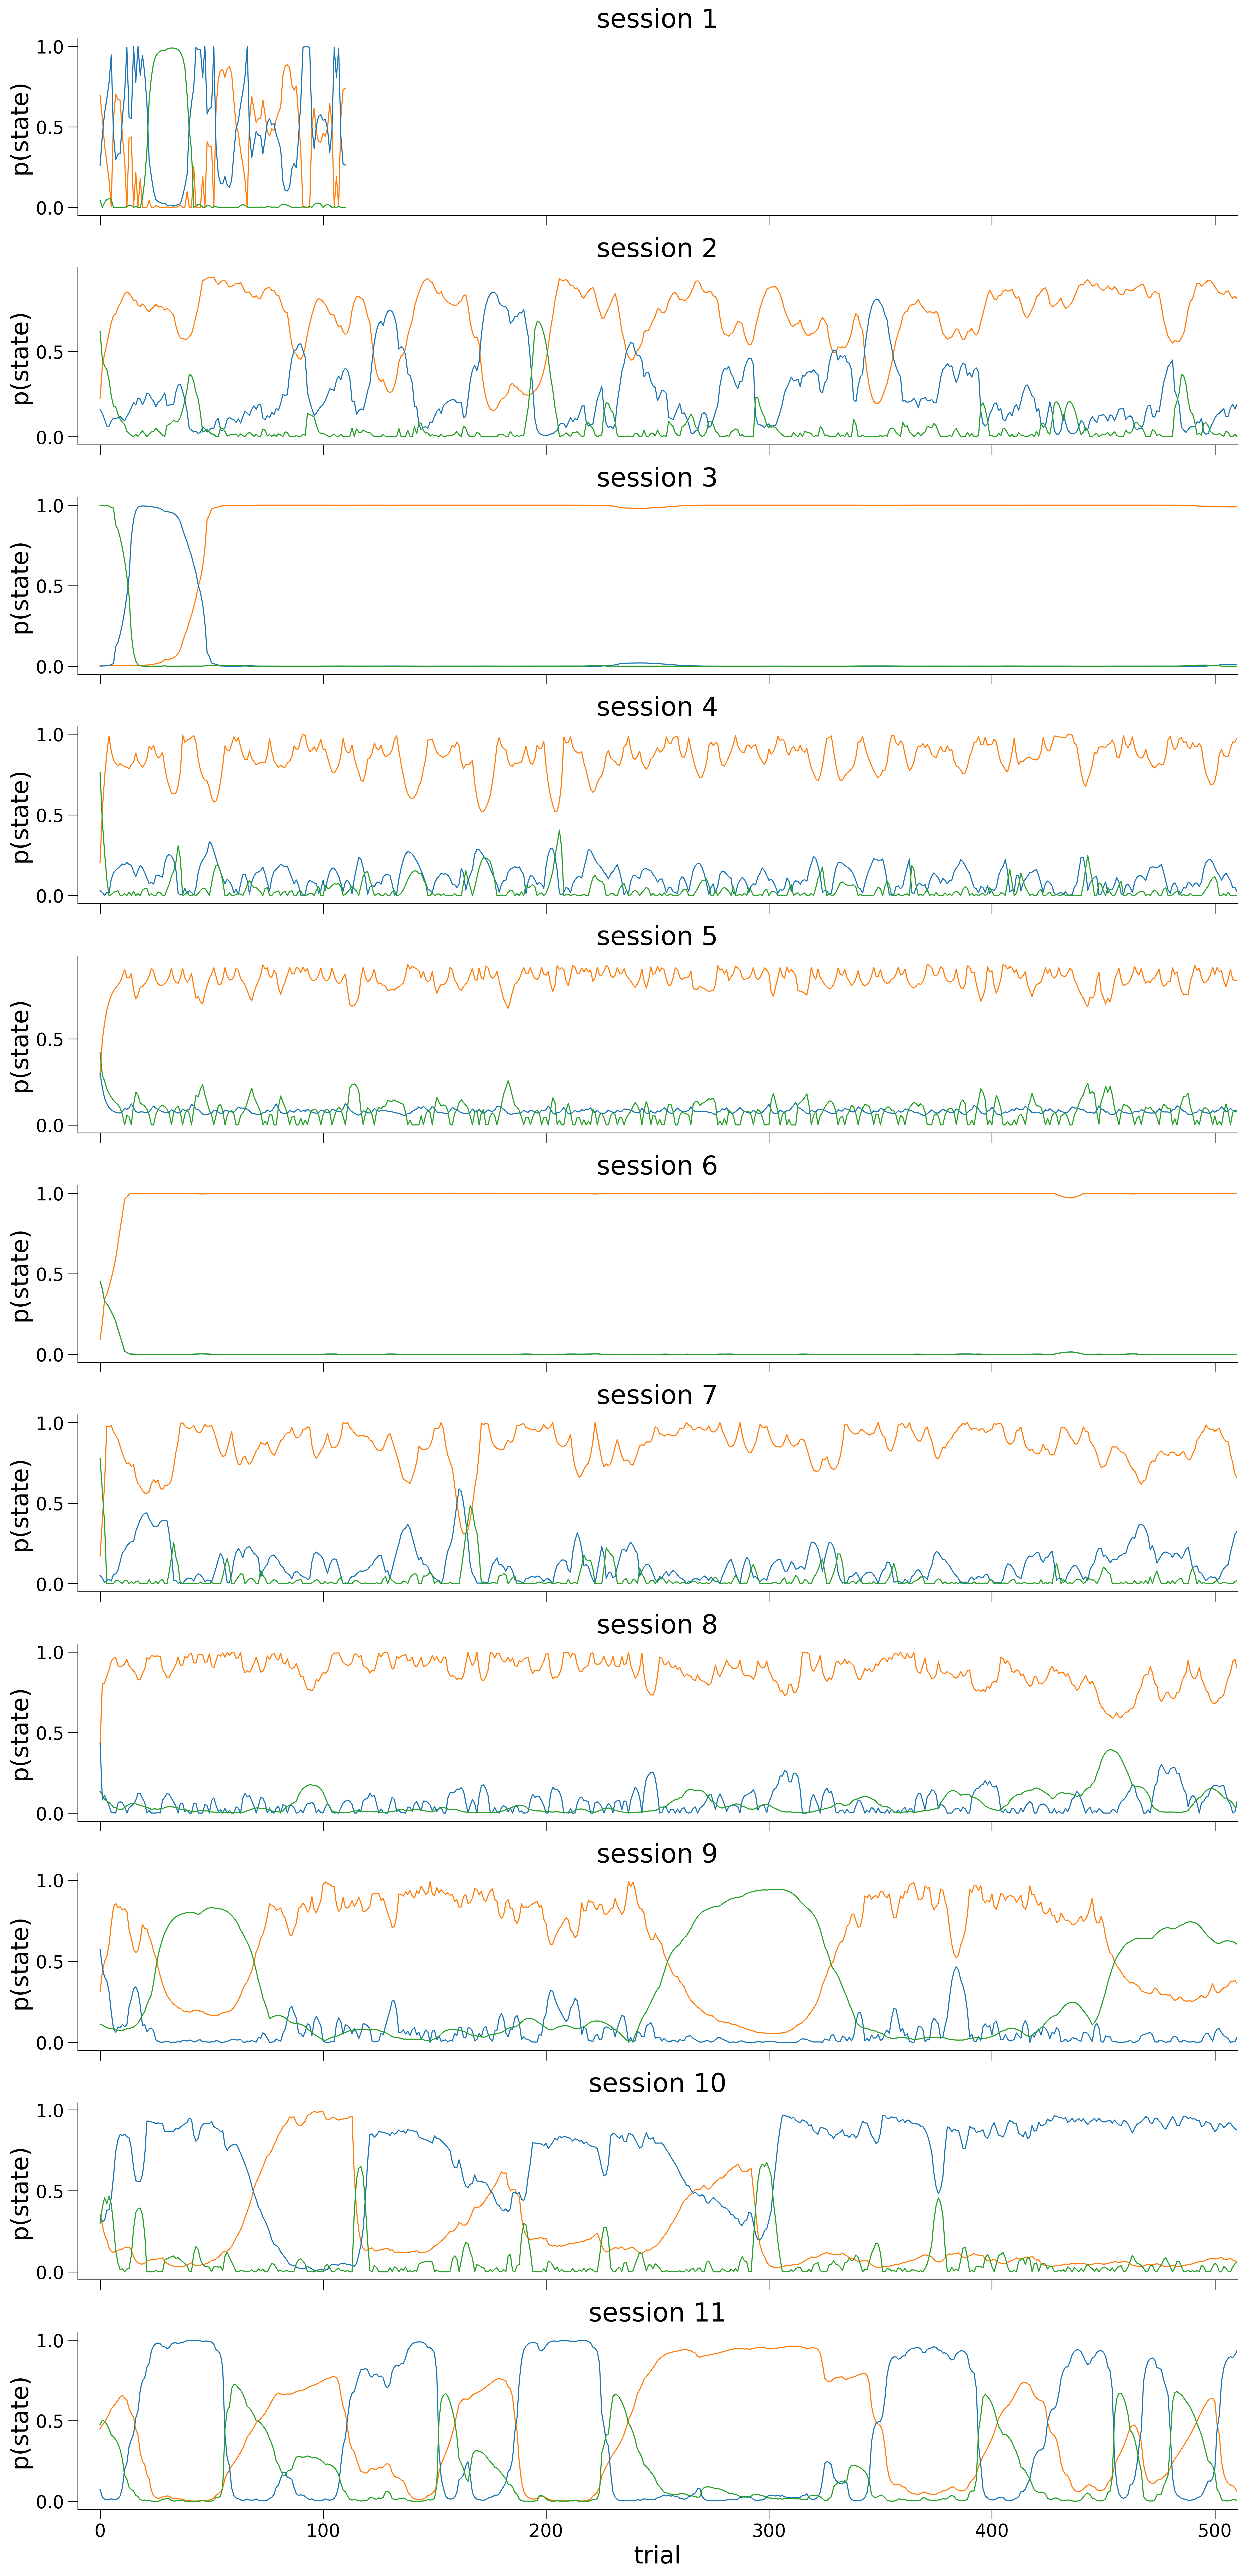

In [ ]:
# plotting inferred likelihood of being in each state for example sessions
sessionsInterest = [0,1,2,3,4,5,6,7,8,9,10]
fig, axes = plt.subplots(len(sessionsInterest), 1, figsize=(16,len(sessionsInterest)*3), dpi=300, sharex=True)
fig.tight_layout(pad=3.5)
plot_posteior_latent(gamma, sessInd, axes, sessions = sessionsInterest, linewidth=1)
for s in range(0,len(sessionsInterest)):
    # sess = sessionsInterest[s]
    # for t in range(sessInd[sess],sessInd[sess+1]):
    #     if (biasedBlockTrials[t] == 1):
    #         axes[s].axvline(t-sessInd[sess], color='tab:blue', label='right block', zorder=0, alpha=0.3, linewidth=0.85)
    #     elif (biasedBlockTrials[t] == -1):
    #         axes[s].axvline(t-sessInd[sess], color='tab:green', label='left block', zorder=0, alpha=0.3, linewidth=0.85)
    axes[s].set_xlim(-10,510)
    axes[s].set_title(f'session {sessionsInterest[s]+1}', size=24, pad=10)
    axes[s].spines[['right', 'top']].set_visible(False)
    axes[s].spines[['left', 'bottom']].set_linewidth(0.75)
    axes[s].get_legend().remove()
    axes[s].set_ylabel('p(state)', size=22)
    axes[s].xaxis.set_tick_params(width=0.75)
    axes[s].yaxis.set_tick_params(width=0.75)
axes[-1].set_xlabel('trial', size=22)
fig.tight_layout()
# plt.savefig(f'../figures/posterior_latent_example-sessions_{subject}.eps', format='eps', bbox_inches='tight', dpi=300)
